In [1]:
import pandas as pd

from sklearn.preprocessing import LabelBinarizer

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

%matplotlib inline

Using TensorFlow backend.


In [2]:
df1 = pd.read_csv('/storage/pdb/pdb_data_no_dups.csv')
df2 = pd.read_csv('/storage/pdb/pdb_data_seq.csv')
df = pd.merge(df1[['structureId','classification','macromoleculeType']], df2[['sequence','structureId']], on='structureId', how='inner')
df.head()


,structureId,classification,macromoleculeType,sequence
0,100D,DNA-RNA HYBRID,DNA/RNA Hybrid,CCGGCGCCGG
1,100D,DNA-RNA HYBRID,DNA/RNA Hybrid,CCGGCGCCGG
2,101D,DNA,DNA,CGCGAATTCGCG
3,101D,DNA,DNA,CGCGAATTCGCG
4,101M,OXYGEN TRANSPORT,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [3]:
df = df[df['macromoleculeType'] == 'Protein']
df.reset_index(inplace=True, drop=True)
df.head()

,structureId,classification,macromoleculeType,sequence
0,101M,OXYGEN TRANSPORT,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1,102L,HYDROLASE(O-GLYCOSYL),Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2,102M,OXYGEN TRANSPORT,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
3,103L,HYDROLASE(O-GLYCOSYL),Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
4,103M,OXYGEN TRANSPORT,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110228 entries, 0 to 110227
Data columns (total 4 columns):
structureId          110228 non-null object
classification       110228 non-null object
macromoleculeType    110228 non-null object
sequence             110227 non-null object
dtypes: object(4)
memory usage: 3.4+ MB


In [5]:
df.dropna(axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110227 entries, 0 to 110227
Data columns (total 4 columns):
structureId          110227 non-null object
classification       110227 non-null object
macromoleculeType    110227 non-null object
sequence             110227 non-null object
dtypes: object(4)
memory usage: 4.2+ MB


In [6]:
df['classification'] = df['classification'].astype('str')
df = df[df['macromoleculeType'] == "Protein"]
df.reset_index(inplace=True, drop=True)

df['classification'] = df['classification'].str.lower()
df['classification'] = df['classification'].str.replace('(', '/')
df['classification'] = df['classification'].str.replace(',', '/')
df['classification'] = df['classification'].str.replace(', ', '/')
df['classification'] = df['classification'].str.replace('/ ', '/')
df['classification'] = df['classification'].str.replace(')', '')
# pattern = '|'.join([', ', ',', '('])
# df['classification'] = df['classification'].str.replace(pattern, '/')

# Maintaing class ordering. There are the same classes with different order 
#ex. viral protein/immune system and immune system/viral protein
df['classification'] = df['classification'].apply(lambda x:"/".join(sorted(x.split('/'))))

df.head(3)

,structureId,classification,macromoleculeType,sequence
0,101M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1,102L,hydrolase/o-glycosyl,Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2,102M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110227 entries, 0 to 110226
Data columns (total 4 columns):
structureId          110227 non-null object
classification       110227 non-null object
macromoleculeType    110227 non-null object
sequence             110227 non-null object
dtypes: object(4)
memory usage: 3.4+ MB


In [8]:
class_dict = dict()
count = 1

classes = df['classification'].value_counts().items()

for cat, num in classes:
    
    # Remove all other classes that have less than 100 number of values 
    if num < 100:
        temp = df['classification'] == cat
        df = df[~temp].copy()
        continue
        
        
        
    if num >= 100:
        class_dict[cat] = count
        count += 1

class_dict

{'hydrolase': 1,
 'transferase': 2,
 'oxidoreductase': 3,
 'lyase': 4,
 'immune system': 5,
 'structural genomics/unknown function': 6,
 'transcription': 7,
 'hydrolase/hydrolase inhibitor': 8,
 'isomerase': 9,
 'signaling protein': 10,
 'viral protein': 11,
 'transport protein': 12,
 'ligase': 13,
 'electron transport': 14,
 'membrane protein': 15,
 'toxin': 16,
 'chaperone': 17,
 'dna binding protein': 18,
 'structural protein': 19,
 'sugar binding protein': 20,
 'metal binding protein': 21,
 'protein binding': 22,
 'virus': 23,
 'unknown function': 24,
 'photosynthesis': 25,
 'contractile protein': 26,
 'cell adhesion': 27,
 'oxygen storage/transport': 28,
 'protein transport': 29,
 'rna binding protein': 30,
 'growth factor/hormone': 31,
 'hormone': 32,
 'cell cycle': 33,
 'metal transport': 34,
 'oxygen transport': 35,
 'apoptosis': 36,
 'blood clotting': 37,
 'gene regulation': 38,
 'biosynthetic protein': 39,
 'lectin': 40,
 'de novo protein': 41,
 'immunoglobulin': 42,
 'transl

In [9]:
df.head()

,structureId,classification,macromoleculeType,sequence
0,101M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1,102L,hydrolase/o-glycosyl,Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2,102M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
3,103L,hydrolase/o-glycosyl,Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
4,103M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [10]:
# Transform labels to one-hot
lb = LabelBinarizer()
Y = lb.fit_transform(df.classification)

In [11]:
max_length = 512 #100 # discared after 512 length
seqs = df.sequence.values
#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(seqs)
#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(seqs)
X = sequence.pad_sequences(X, maxlen=max_length)


In [13]:
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.layers as layers
from keras import regularizers
import keras.models as models



In [17]:
embedding_dim = 8
top_classes = 85

model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_length))
model.add(Conv1D(filters=64, kernel_size=6, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(top_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 512, 8)            208       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 512, 64)           3136      
_________________________________________________________________
activation_4 (Activation)    (None, 512, 64)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512, 64)           256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 256, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 256, 32)           6176      
_________________________________________________________________
activation_5 (Activation)    (None, 256, 32)          

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=42)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, callbacks=[es])


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 75100 samples, validate on 18776 samples
Epoch 1/200
75100/75100 [==============================] - 82s 1ms/step - loss: 1.8502 - accuracy: 0.5609 - val_loss: 1.3988 - val_accuracy: 0.6636
Epoch 2/200
75100/75100 [==============================] - 81s 1ms/step - loss: 1.0015 - accuracy: 0.7477 - val_loss: 1.2933 - val_accuracy: 0.6972
Epoch 3/200
75100/75100 [==============================] - 81s 1ms/step - loss: 0.7349 - accuracy: 0.8037 - val_loss: 1.0858 - val_accuracy: 0.7591
Epoch 4/200
75100/75100 [==============================] - 81s 1ms/step - loss: 0.5910 - accuracy: 0.8369 - val_loss: 1.1981 - val_accuracy: 0.7554
Epoch 5/200
75100/75100 [==============================] - 81s 1ms/step - loss: 0.5031 - accuracy: 0.8577 - val_loss: 1.0865 - val_accuracy: 0.7863
Epoch 6/200
75100/75100 [==============================] - 81s 1ms/step - loss: 0.4352 - accuracy: 0.8730 - val_loss: 1.0823 - val_accuracy: 0.7889
Epoch 7/200
75100/75100 [==============================] - 81s

In [19]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train-acc = 0.9233954727030625
test-acc = 0.8128994461014061


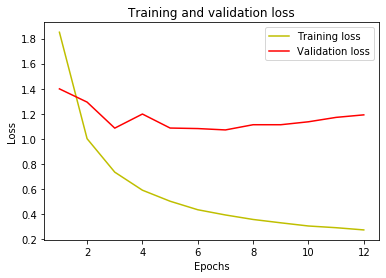

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

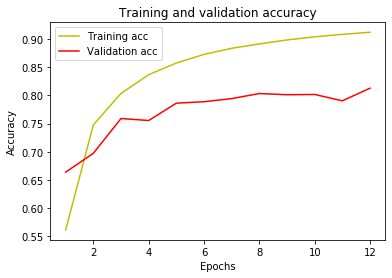

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()